In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv("Tweets.csv")
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
df = data[['airline_sentiment', 'text']]
df.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [5]:
df.nunique()

airline_sentiment        3
text                 14427
dtype: int64

In [6]:
df.airline_sentiment

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object

In [7]:
counts = df['airline_sentiment'].value_counts()
pd.DataFrame(counts)

,airline_sentiment
negative,9178
neutral,3099
positive,2363


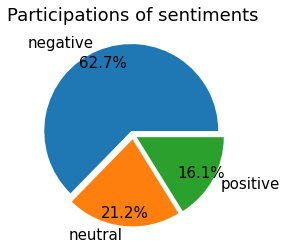

In [8]:
plt.title('Participations of sentiments', fontsize=18)
plt.pie(counts,
        labels=counts.index,
        autopct='%1.1f%%',
        pctdistance=0.85,
        explode = [0.05] * 3,
        textprops={'fontsize': 15})
#plt.tight_layout()
plt.show()

In [9]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

D:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hefen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def remove_hashtags(tokens):
    tokens = map(lambda x: x.replace('#', ''), tokens)
    return list(tokens)

def remove_url(tokens):
    tokens = filter(lambda x: "http" not in x, tokens)
    return list(tokens)

def remove_html(tokens):
    tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
    return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags_4tweets(corpus):
    ''' modified version for our data structure (flattened and only for tweets proc)'''
    tokenizer = TweetTokenizer() 
    tokenized_sentences = []
    for sample in tqdm(corpus):
        ## we remove sentence split as we need to keep the whole tweet as one
        # # separating sentences
        # for sentence in sent_detector.tokenize(sample):
        tokens = tokenizer.tokenize(sample)
        tokens = remove_url(tokens)
        tokens = remove_html(tokens)
        tokens = remove_hashtags(tokens)
        tokens = list(map(lambda x: x.lower(), tokens))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

In [11]:
X_clean = tokenize_url_hashtags_4tweets(df.text.array)
X = [' '.join(x) for x in X_clean]
print(len(X), X[0])
print(len(df.text.array), df.text.array[0])


100%|██████████| 14640/14640 [00:00<00:00, 15777.48it/s]

14640 @virginamerica what @dhepburn said .
14640 @VirginAmerica What @dhepburn said.


In [12]:
pd.DataFrame(X)

,0
0,@virginamerica what @dhepburn said .
1,@virginamerica plus you've added commercials t...
2,@virginamerica i didn't today ... must mean i ...
3,@virginamerica it's really aggressive to blast...
4,@virginamerica and it's a really big bad thing...
...,...
14635,@americanair thank you we got on a different f...
14636,@americanair leaving over 20 minutes late flig...
14637,@americanair please bring american airlines to...
14638,"@americanair you have my money , you change my..."


In [13]:
y = df.airline_sentiment
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)


Processing Text (X)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(8784, 10520)

In [15]:
# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(2928, 10520)

Processing Labels (y)

In [16]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(8784, 3) (2928, 3)


In [17]:
def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()


In [18]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      1855
     neutral       0.66      0.38      0.48       607
    positive       0.86      0.44      0.58       466

    accuracy                           0.76      2928
   macro avg       0.76      0.59      0.64      2928
weighted avg       0.76      0.76      0.73      2928



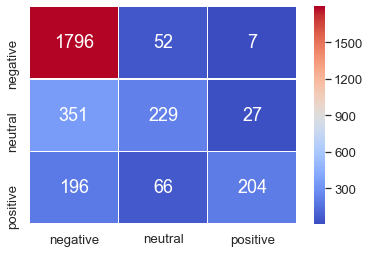

negative 0.887313700911619
neutral 0.8401657525622016
positive 0.8989123954494583


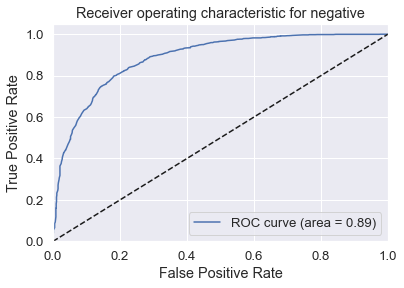

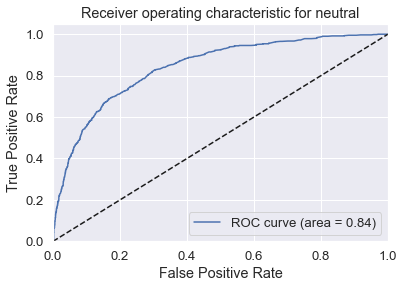

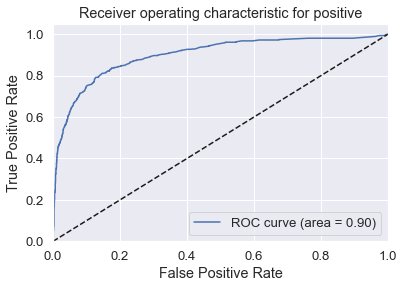

In [19]:
y_score_rfc = rfc.predict_proba(X_dev_cv) # you can also try .predict_log_proba(X_dev_cv)
y_score_rfc = np.array(y_score_rfc) # transform it to numpy array for easier manipulation
classes_proba = (class_binary_proba[:,1] for class_binary_proba in y_score_rfc)
y_score_rfc = np.column_stack(classes_proba)

show_eval(y_dev_lb, y_score_rfc, lb_trained, rfc )

In [20]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))


The virtual instance has 8 cpus, that will be used to train the word2vec model


In [21]:
tweetswv = Word2Vec(X_clean, vector_size=100, window=5, min_count=1, workers=cpu, sg=0)
tweetswv.train(X_clean, total_examples=len(X_clean), epochs=100)
tweets_wv = tweetswv.wv

In [22]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus):
    ''' transforms our X into a list of list of vec (2D array) '''
    new_sample = list()
    for sample in tokenCorpus:
        tweetVecs = list()
        for token in sample.split(' '):
            try: tweetVecs.append(tweets_wv.get_vector(token)  )
            except: tweetVecs.append( np.zeros(100) ) 
        new_sample.append(np.mean(tweetVecs, axis=0))
    return np.array(new_sample)


X_train_vec = tokens2vectors(X_train)
print(X_train_vec.shape, X_train_cv.shape)
# print(type(X_train_cv.toarray()), type(X_train_vec))
X_dev_vec = tokens2vectors(X_dev)
X_test_vec = tokens2vectors(X_test)


(8784, 100) (8784, 10520)


In [23]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_vec, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


              precision    recall  f1-score   support

    negative       0.76      0.97      0.85      1855
     neutral       0.71      0.34      0.46       607
    positive       0.79      0.47      0.59       466

    accuracy                           0.76      2928
   macro avg       0.75      0.59      0.64      2928
weighted avg       0.76      0.76      0.73      2928



D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


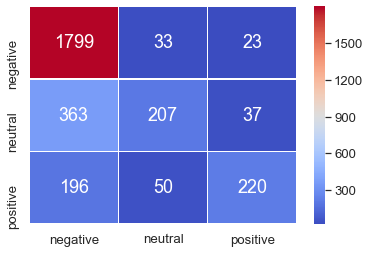

negative 0.8706051250618589
neutral 0.8276867537780895
positive 0.8927195517793203


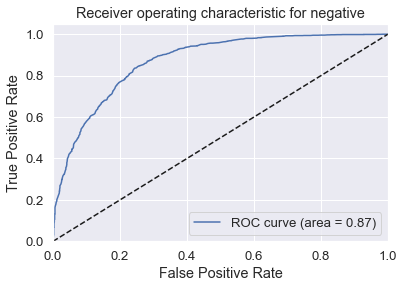

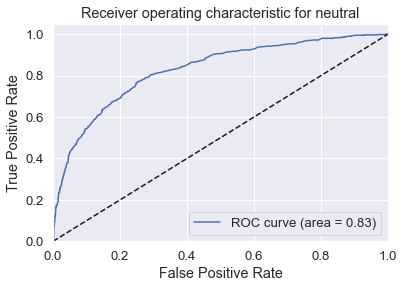

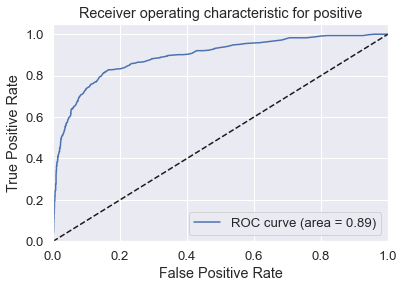

In [24]:
y_score_rfc = rfc.predict_proba(X_dev_vec)
y_score_rfc = np.array(y_score_rfc) 
classes_proba = (class_binary_proba[:,1] for class_binary_proba in y_score_rfc)
y_score_rfc = np.column_stack(classes_proba)

show_eval(y_dev_lb, y_score_rfc, lb_trained, rfc )

In [25]:
#define Hyper parameters;

Input_size = 100
Hidden_size = 128 
Epochs = 50
batch_size = 128

class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(
            input_size=Input_size,
            hidden_size=Hidden_size,
            batch_first=True)
        self.fc = nn.Linear(128, 3)
        
    def forward(self, x):
        out, (h_0, c_0) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = F.softmax(out, dim= 1)
        return out, h_0

model = lstm()
optimizer = torch.optim.Adam(model.parameters())


In [26]:
def tokens2lists(tokenCorpus):
    new_sample = list()
    for sample in tokenCorpus:
        tweetVecs = list()
        for token in sample.split(' '):
            try: tweetVecs.append(tweets_wv.get_vector(token)  )
            except: tweetVecs.append( np.zeros(100) ) 
        new_sample.append(tweetVecs)
    return new_sample


In [27]:
lengh = 42
def addlengh(X_vec):
    tensors = list()
    for sample in X_vec:
        sample_len = len(sample)
        for i in range(sample_len, lengh):
            sample.append(np.zeros(100))
    return X_vec

In [28]:
X_vec = tokens2lists(X)
X_vec = addlengh(X_vec)

y_lb = lb_trained.transform(y)
train_X, test_X, train_Y, test_Y = train_test_split(X_vec, y_lb, test_size=0.2, random_state=42)

In [29]:
train_X = torch.FloatTensor(train_X)
train_Y = torch.from_numpy(train_Y)
test_X = torch.FloatTensor(test_X)
test_Y = torch.from_numpy(test_Y)

train_Y = train_Y.argmax(axis=1)
test_Y = test_Y.argmax(axis=1)

train_data = Data.TensorDataset(train_X, train_Y)
test_data = Data.TensorDataset(test_X, test_Y)

train_loader = Data.DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_loader = Data.DataLoader(test_data, batch_size= batch_size, shuffle=False)


In [30]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):        
        optimizer.zero_grad()
        output, h_state = model(data)
        labels = output.argmax(dim= 1)
        acc = accuracy_score(target, labels)
        
        optimizer.zero_grad()
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        
        if (batch_idx+1)%2 == 0:
            finish_rate = (batch_idx* len(data) / len(train_X))*100
            print('Train Epoch: %s'%str(epoch), #Train Epoch: 1
                  '[%d/%d]--'%((batch_idx* len(data)),len(train_X)), #[1450/60000]
                  '%.3f%%'%finish_rate, #0.024
                 '\t', 'acc: %.5f'%acc, #acc: 0.98000
                 '  loss: %s'%loss.item()) #loss: 1.4811499118804932
            


In [31]:
def valid(model, test_loader):
    model.eval()
    test_loss = 0
    acc = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            output, h_state = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            output = output.argmax(dim = 1)
            y_true.extend(target)
            y_pred.extend(output)
    acc = accuracy_score(y_true, y_pred)
    #print(classification_report(y_true, y_pred, digits= 5))
    test_loss /= len(test_X)
    
    print('Valid set: Avg Loss:%s'%str(test_loss),
         '\t', 'Avg acc:%s'%str(acc))
    

In [32]:
def test(model, test_loader):
    model.eval()
    y_true = []
    y_pre = []
    for data, target in test_loader:
        output, h_state = model(data)
        output = output.argmax(dim= 1)
        y_true.extend(target)
        y_pre.extend(output)
    print(classification_report(y_true, y_pre, digits= 5))


In [33]:
for epoch in tqdm(range(1, 50)):
    train(model, train_loader, optimizer, epoch)
    valid(model, test_loader)
    print('============================================================================')
print('**********************test set*************************')
test(model, test_loader)


  0%|          | 0/49 [00:00<?, ?it/s]

Train Epoch: 1 [128/11712]-- 1.093% 	 acc: 0.23438   loss: 1.0995934009552002
Train Epoch: 1 [384/11712]-- 3.279% 	 acc: 0.25781   loss: 1.0930397510528564
Train Epoch: 1 [640/11712]-- 5.464% 	 acc: 0.68750   loss: 1.0835864543914795
Train Epoch: 1 [896/11712]-- 7.650% 	 acc: 0.67188   loss: 1.0758702754974365
Train Epoch: 1 [1152/11712]-- 9.836% 	 acc: 0.61719   loss: 1.0647886991500854
Train Epoch: 1 [1408/11712]-- 12.022% 	 acc: 0.60938   loss: 1.0460116863250732
Train Epoch: 1 [1664/11712]-- 14.208% 	 acc: 0.63281   loss: 0.989397406578064
Train Epoch: 1 [1920/11712]-- 16.393% 	 acc: 0.57812   loss: 0.9742324352264404
Train Epoch: 1 [2176/11712]-- 18.579% 	 acc: 0.59375   loss: 0.9584259390830994
Train Epoch: 1 [2432/11712]-- 20.765% 	 acc: 0.64062   loss: 0.91201251745224
Train Epoch: 1 [2688/11712]-- 22.951% 	 acc: 0.64844   loss: 0.9037609100341797
Train Epoch: 1 [2944/11712]-- 25.137% 	 acc: 0.62500   loss: 0.926825761795044
Train Epoch: 1 [3200/11712]-- 27.322% 	 acc: 0.62500 

  2%|▏         | 1/49 [00:10<08:23, 10.50s/it]

Valid set: Avg Loss:0.906334900465168 	 Avg acc:0.6451502732240437
Train Epoch: 2 [128/11712]-- 1.093% 	 acc: 0.65625   loss: 0.8952382206916809
Train Epoch: 2 [384/11712]-- 3.279% 	 acc: 0.64844   loss: 0.9030530452728271
Train Epoch: 2 [640/11712]-- 5.464% 	 acc: 0.60156   loss: 0.9499015212059021
Train Epoch: 2 [896/11712]-- 7.650% 	 acc: 0.63281   loss: 0.9186590909957886
Train Epoch: 2 [1152/11712]-- 9.836% 	 acc: 0.64062   loss: 0.9108478426933289
Train Epoch: 2 [1408/11712]-- 12.022% 	 acc: 0.66406   loss: 0.8874340653419495
Train Epoch: 2 [1664/11712]-- 14.208% 	 acc: 0.64062   loss: 0.9108532667160034
Train Epoch: 2 [1920/11712]-- 16.393% 	 acc: 0.60156   loss: 0.9498870968818665
Train Epoch: 2 [2176/11712]-- 18.579% 	 acc: 0.64844   loss: 0.9030508995056152
Train Epoch: 2 [2432/11712]-- 20.765% 	 acc: 0.59375   loss: 0.9577066898345947
Train Epoch: 2 [2688/11712]-- 22.951% 	 acc: 0.63281   loss: 0.9186607599258423
Train Epoch: 2 [2944/11712]-- 25.137% 	 acc: 0.58594   loss: 0

  4%|▍         | 2/49 [00:20<08:13, 10.49s/it]

Valid set: Avg Loss:0.9063212728239799 	 Avg acc:0.6451502732240437
Train Epoch: 3 [128/11712]-- 1.093% 	 acc: 0.64062   loss: 0.9108449816703796
Train Epoch: 3 [384/11712]-- 3.279% 	 acc: 0.63281   loss: 0.9186525940895081
Train Epoch: 3 [640/11712]-- 5.464% 	 acc: 0.60938   loss: 0.9420803189277649
Train Epoch: 3 [896/11712]-- 7.650% 	 acc: 0.63281   loss: 0.918651282787323
Train Epoch: 3 [1152/11712]-- 9.836% 	 acc: 0.57812   loss: 0.9733179211616516
Train Epoch: 3 [1408/11712]-- 12.022% 	 acc: 0.60938   loss: 0.9420783519744873
Train Epoch: 3 [1664/11712]-- 14.208% 	 acc: 0.67188   loss: 0.879604697227478
Train Epoch: 3 [1920/11712]-- 16.393% 	 acc: 0.63281   loss: 0.9186514019966125
Train Epoch: 3 [2176/11712]-- 18.579% 	 acc: 0.70312   loss: 0.8483659029006958
Train Epoch: 3 [2432/11712]-- 20.765% 	 acc: 0.63281   loss: 0.9186522960662842
Train Epoch: 3 [2688/11712]-- 22.951% 	 acc: 0.61719   loss: 0.9342744946479797
Train Epoch: 3 [2944/11712]-- 25.137% 	 acc: 0.64062   loss: 0.

  6%|▌         | 3/49 [00:31<08:05, 10.56s/it]

Valid set: Avg Loss:0.9063113348080161 	 Avg acc:0.6451502732240437
Train Epoch: 4 [128/11712]-- 1.093% 	 acc: 0.60938   loss: 0.942072331905365
Train Epoch: 4 [384/11712]-- 3.279% 	 acc: 0.64844   loss: 0.9030231833457947
Train Epoch: 4 [640/11712]-- 5.464% 	 acc: 0.58594   loss: 0.9655039310455322
Train Epoch: 4 [896/11712]-- 7.650% 	 acc: 0.51562   loss: 1.0358024835586548
Train Epoch: 4 [1152/11712]-- 9.836% 	 acc: 0.63281   loss: 0.918646514415741
Train Epoch: 4 [1408/11712]-- 12.022% 	 acc: 0.62500   loss: 0.9264578223228455
Train Epoch: 4 [1664/11712]-- 14.208% 	 acc: 0.54688   loss: 1.0045596361160278
Train Epoch: 4 [1920/11712]-- 16.393% 	 acc: 0.63281   loss: 0.9186466336250305
Train Epoch: 4 [2176/11712]-- 18.579% 	 acc: 0.66406   loss: 0.8874022960662842
Train Epoch: 4 [2432/11712]-- 20.765% 	 acc: 0.57031   loss: 0.9811272621154785
Train Epoch: 4 [2688/11712]-- 22.951% 	 acc: 0.60156   loss: 0.9498873353004456
Train Epoch: 4 [2944/11712]-- 25.137% 	 acc: 0.62500   loss: 0.

  8%|▊         | 4/49 [00:41<07:44, 10.31s/it]

Valid set: Avg Loss:0.9063062589676654 	 Avg acc:0.6451502732240437
Train Epoch: 5 [128/11712]-- 1.093% 	 acc: 0.58594   loss: 0.9655076265335083
Train Epoch: 5 [384/11712]-- 3.279% 	 acc: 0.65625   loss: 0.8952113389968872
Train Epoch: 5 [640/11712]-- 5.464% 	 acc: 0.64062   loss: 0.9108309745788574
Train Epoch: 5 [896/11712]-- 7.650% 	 acc: 0.60156   loss: 0.9498847723007202
Train Epoch: 5 [1152/11712]-- 9.836% 	 acc: 0.60938   loss: 0.9420751333236694
Train Epoch: 5 [1408/11712]-- 12.022% 	 acc: 0.63281   loss: 0.9186397790908813
Train Epoch: 5 [1664/11712]-- 14.208% 	 acc: 0.61719   loss: 0.9342629313468933
Train Epoch: 5 [1920/11712]-- 16.393% 	 acc: 0.53125   loss: 1.0201843976974487
Train Epoch: 5 [2176/11712]-- 18.579% 	 acc: 0.62500   loss: 0.9264538288116455
Train Epoch: 5 [2432/11712]-- 20.765% 	 acc: 0.63281   loss: 0.9186404347419739
Train Epoch: 5 [2688/11712]-- 22.951% 	 acc: 0.62500   loss: 0.926450788974762
Train Epoch: 5 [2944/11712]-- 25.137% 	 acc: 0.57812   loss: 0

 10%|█         | 5/49 [00:52<07:46, 10.61s/it]

Valid set: Avg Loss:0.9063029862492462 	 Avg acc:0.6451502732240437
Train Epoch: 6 [128/11712]-- 1.093% 	 acc: 0.65625   loss: 0.8952057957649231
Train Epoch: 6 [384/11712]-- 3.279% 	 acc: 0.61719   loss: 0.9342606067657471
Train Epoch: 6 [640/11712]-- 5.464% 	 acc: 0.59375   loss: 0.9576926827430725
Train Epoch: 6 [896/11712]-- 7.650% 	 acc: 0.54688   loss: 1.0045605897903442
Train Epoch: 6 [1152/11712]-- 9.836% 	 acc: 0.67969   loss: 0.8717714548110962
Train Epoch: 6 [1408/11712]-- 12.022% 	 acc: 0.51562   loss: 1.035805344581604
Train Epoch: 6 [1664/11712]-- 14.208% 	 acc: 0.66406   loss: 0.8873924016952515
Train Epoch: 6 [1920/11712]-- 16.393% 	 acc: 0.63281   loss: 0.9186370372772217
Train Epoch: 6 [2176/11712]-- 18.579% 	 acc: 0.58594   loss: 0.9655050039291382
Train Epoch: 6 [2432/11712]-- 20.765% 	 acc: 0.65625   loss: 0.8952056169509888
Train Epoch: 6 [2688/11712]-- 22.951% 	 acc: 0.50781   loss: 1.0436221361160278
Train Epoch: 6 [2944/11712]-- 25.137% 	 acc: 0.59375   loss: 0

 12%|█▏        | 6/49 [01:05<08:01, 11.21s/it]

Valid set: Avg Loss:0.9062990751422819 	 Avg acc:0.6451502732240437
Train Epoch: 7 [128/11712]-- 1.093% 	 acc: 0.68750   loss: 0.8639565706253052
Train Epoch: 7 [384/11712]-- 3.279% 	 acc: 0.61719   loss: 0.9342546463012695
Train Epoch: 7 [640/11712]-- 5.464% 	 acc: 0.60156   loss: 0.9498772025108337
Train Epoch: 7 [896/11712]-- 7.650% 	 acc: 0.61719   loss: 0.9342570304870605
Train Epoch: 7 [1152/11712]-- 9.836% 	 acc: 0.58594   loss: 0.9655017852783203
Train Epoch: 7 [1408/11712]-- 12.022% 	 acc: 0.60156   loss: 0.9498785734176636
Train Epoch: 7 [1664/11712]-- 14.208% 	 acc: 0.65625   loss: 0.8951994180679321
Train Epoch: 7 [1920/11712]-- 16.393% 	 acc: 0.62500   loss: 0.9264476299285889
Train Epoch: 7 [2176/11712]-- 18.579% 	 acc: 0.62500   loss: 0.9264439940452576
Train Epoch: 7 [2432/11712]-- 20.765% 	 acc: 0.61719   loss: 0.9342561960220337
Train Epoch: 7 [2688/11712]-- 22.951% 	 acc: 0.62500   loss: 0.9264433979988098
Train Epoch: 7 [2944/11712]-- 25.137% 	 acc: 0.66406   loss: 

 14%|█▍        | 7/49 [01:17<08:01, 11.46s/it]

Valid set: Avg Loss:0.9062922196310075 	 Avg acc:0.6451502732240437
Train Epoch: 8 [128/11712]-- 1.093% 	 acc: 0.64062   loss: 0.9108228087425232
Train Epoch: 8 [384/11712]-- 3.279% 	 acc: 0.67969   loss: 0.8717578053474426
Train Epoch: 8 [640/11712]-- 5.464% 	 acc: 0.60938   loss: 0.9420657157897949
Train Epoch: 8 [896/11712]-- 7.650% 	 acc: 0.62500   loss: 0.9264405965805054
Train Epoch: 8 [1152/11712]-- 9.836% 	 acc: 0.64844   loss: 0.9030022621154785
Train Epoch: 8 [1408/11712]-- 12.022% 	 acc: 0.67969   loss: 0.8717557191848755
Train Epoch: 8 [1664/11712]-- 14.208% 	 acc: 0.60156   loss: 0.9498685002326965
Train Epoch: 8 [1920/11712]-- 16.393% 	 acc: 0.64844   loss: 0.9030011892318726
Train Epoch: 8 [2176/11712]-- 18.579% 	 acc: 0.60938   loss: 0.9420629739761353
Train Epoch: 8 [2432/11712]-- 20.765% 	 acc: 0.57031   loss: 0.9811111688613892
Train Epoch: 8 [2688/11712]-- 22.951% 	 acc: 0.70312   loss: 0.848321259021759
Train Epoch: 8 [2944/11712]-- 25.137% 	 acc: 0.63281   loss: 0

 16%|█▋        | 8/49 [01:27<07:34, 11.08s/it]

Valid set: Avg Loss:0.8909779767521092 	 Avg acc:0.6451502732240437
Train Epoch: 9 [128/11712]-- 1.093% 	 acc: 0.64844   loss: 0.8753120303153992
Train Epoch: 9 [384/11712]-- 3.279% 	 acc: 0.71875   loss: 0.8526962995529175
Train Epoch: 9 [640/11712]-- 5.464% 	 acc: 0.70312   loss: 0.8715369701385498
Train Epoch: 9 [896/11712]-- 7.650% 	 acc: 0.68750   loss: 0.8680406808853149
Train Epoch: 9 [1152/11712]-- 9.836% 	 acc: 0.60156   loss: 0.9553931951522827
Train Epoch: 9 [1408/11712]-- 12.022% 	 acc: 0.66406   loss: 0.8918449282646179
Train Epoch: 9 [1664/11712]-- 14.208% 	 acc: 0.66406   loss: 0.902809202671051
Train Epoch: 9 [1920/11712]-- 16.393% 	 acc: 0.74219   loss: 0.8168151378631592
Train Epoch: 9 [2176/11712]-- 18.579% 	 acc: 0.71875   loss: 0.8379173874855042
Train Epoch: 9 [2432/11712]-- 20.765% 	 acc: 0.67969   loss: 0.88152676820755
Train Epoch: 9 [2688/11712]-- 22.951% 	 acc: 0.62500   loss: 0.9037808775901794
Train Epoch: 9 [2944/11712]-- 25.137% 	 acc: 0.64062   loss: 0.8

 18%|█▊        | 9/49 [01:37<07:16, 10.91s/it]

Valid set: Avg Loss:0.807655352712329 	 Avg acc:0.730191256830601
Train Epoch: 10 [128/11712]-- 1.093% 	 acc: 0.69531   loss: 0.8339937925338745
Train Epoch: 10 [384/11712]-- 3.279% 	 acc: 0.65625   loss: 0.8707120418548584
Train Epoch: 10 [640/11712]-- 5.464% 	 acc: 0.61719   loss: 0.8895891904830933
Train Epoch: 10 [896/11712]-- 7.650% 	 acc: 0.71094   loss: 0.8123403191566467
Train Epoch: 10 [1152/11712]-- 9.836% 	 acc: 0.69531   loss: 0.8286019563674927
Train Epoch: 10 [1408/11712]-- 12.022% 	 acc: 0.72656   loss: 0.8122126460075378
Train Epoch: 10 [1664/11712]-- 14.208% 	 acc: 0.61719   loss: 0.9176433682441711
Train Epoch: 10 [1920/11712]-- 16.393% 	 acc: 0.61719   loss: 0.8872410655021667
Train Epoch: 10 [2176/11712]-- 18.579% 	 acc: 0.70312   loss: 0.8239171504974365
Train Epoch: 10 [2432/11712]-- 20.765% 	 acc: 0.71094   loss: 0.8134052157402039
Train Epoch: 10 [2688/11712]-- 22.951% 	 acc: 0.70312   loss: 0.8000982999801636
Train Epoch: 10 [2944/11712]-- 25.137% 	 acc: 0.6406

 20%|██        | 10/49 [01:48<07:00, 10.78s/it]

Valid set: Avg Loss:0.8033065743785087 	 Avg acc:0.7332650273224044
Train Epoch: 11 [128/11712]-- 1.093% 	 acc: 0.73438   loss: 0.8052042126655579
Train Epoch: 11 [384/11712]-- 3.279% 	 acc: 0.74219   loss: 0.806190013885498
Train Epoch: 11 [640/11712]-- 5.464% 	 acc: 0.72656   loss: 0.8166832327842712
Train Epoch: 11 [896/11712]-- 7.650% 	 acc: 0.64062   loss: 0.8848735690116882
Train Epoch: 11 [1152/11712]-- 9.836% 	 acc: 0.66406   loss: 0.8561244606971741
Train Epoch: 11 [1408/11712]-- 12.022% 	 acc: 0.68750   loss: 0.8353717923164368
Train Epoch: 11 [1664/11712]-- 14.208% 	 acc: 0.70312   loss: 0.8214946985244751
Train Epoch: 11 [1920/11712]-- 16.393% 	 acc: 0.74219   loss: 0.8089712858200073
Train Epoch: 11 [2176/11712]-- 18.579% 	 acc: 0.73438   loss: 0.8026481866836548
Train Epoch: 11 [2432/11712]-- 20.765% 	 acc: 0.66406   loss: 0.8372166156768799
Train Epoch: 11 [2688/11712]-- 22.951% 	 acc: 0.76562   loss: 0.7866010665893555
Train Epoch: 11 [2944/11712]-- 25.137% 	 acc: 0.765

 22%|██▏       | 11/49 [01:58<06:45, 10.66s/it]

Valid set: Avg Loss:0.7977595954644875 	 Avg acc:0.7397540983606558
Train Epoch: 12 [128/11712]-- 1.093% 	 acc: 0.70312   loss: 0.8313556909561157
Train Epoch: 12 [384/11712]-- 3.279% 	 acc: 0.60156   loss: 0.9019725322723389
Train Epoch: 12 [640/11712]-- 5.464% 	 acc: 0.78125   loss: 0.7798877358436584
Train Epoch: 12 [896/11712]-- 7.650% 	 acc: 0.79688   loss: 0.7523211240768433
Train Epoch: 12 [1152/11712]-- 9.836% 	 acc: 0.75000   loss: 0.8126547932624817
Train Epoch: 12 [1408/11712]-- 12.022% 	 acc: 0.78125   loss: 0.7743217349052429
Train Epoch: 12 [1664/11712]-- 14.208% 	 acc: 0.75781   loss: 0.804229736328125
Train Epoch: 12 [1920/11712]-- 16.393% 	 acc: 0.76562   loss: 0.7883694171905518
Train Epoch: 12 [2176/11712]-- 18.579% 	 acc: 0.78125   loss: 0.7586185336112976
Train Epoch: 12 [2432/11712]-- 20.765% 	 acc: 0.75781   loss: 0.7838864326477051
Train Epoch: 12 [2688/11712]-- 22.951% 	 acc: 0.67969   loss: 0.8450897336006165
Train Epoch: 12 [2944/11712]-- 25.137% 	 acc: 0.687

 24%|██▍       | 12/49 [02:09<06:32, 10.61s/it]

Valid set: Avg Loss:0.797260156746119 	 Avg acc:0.7435109289617486
Train Epoch: 13 [128/11712]-- 1.093% 	 acc: 0.75781   loss: 0.7944019436836243
Train Epoch: 13 [384/11712]-- 3.279% 	 acc: 0.76562   loss: 0.7871888279914856
Train Epoch: 13 [640/11712]-- 5.464% 	 acc: 0.69531   loss: 0.8431888222694397
Train Epoch: 13 [896/11712]-- 7.650% 	 acc: 0.71094   loss: 0.842140257358551
Train Epoch: 13 [1152/11712]-- 9.836% 	 acc: 0.70312   loss: 0.8293123245239258
Train Epoch: 13 [1408/11712]-- 12.022% 	 acc: 0.75781   loss: 0.795111358165741
Train Epoch: 13 [1664/11712]-- 14.208% 	 acc: 0.77344   loss: 0.7770664095878601
Train Epoch: 13 [1920/11712]-- 16.393% 	 acc: 0.78906   loss: 0.7647295594215393
Train Epoch: 13 [2176/11712]-- 18.579% 	 acc: 0.78125   loss: 0.7739187479019165
Train Epoch: 13 [2432/11712]-- 20.765% 	 acc: 0.75000   loss: 0.8109763264656067
Train Epoch: 13 [2688/11712]-- 22.951% 	 acc: 0.71094   loss: 0.8262441754341125
Train Epoch: 13 [2944/11712]-- 25.137% 	 acc: 0.70312

 27%|██▋       | 13/49 [02:19<06:22, 10.63s/it]

Valid set: Avg Loss:0.7823062646584432 	 Avg acc:0.7657103825136612
Train Epoch: 14 [128/11712]-- 1.093% 	 acc: 0.80469   loss: 0.747776210308075
Train Epoch: 14 [384/11712]-- 3.279% 	 acc: 0.81250   loss: 0.7448463439941406
Train Epoch: 14 [640/11712]-- 5.464% 	 acc: 0.76562   loss: 0.7940067052841187
Train Epoch: 14 [896/11712]-- 7.650% 	 acc: 0.81250   loss: 0.7478957772254944
Train Epoch: 14 [1152/11712]-- 9.836% 	 acc: 0.77344   loss: 0.7769889235496521
Train Epoch: 14 [1408/11712]-- 12.022% 	 acc: 0.78906   loss: 0.7637455463409424
Train Epoch: 14 [1664/11712]-- 14.208% 	 acc: 0.75000   loss: 0.8017009496688843
Train Epoch: 14 [1920/11712]-- 16.393% 	 acc: 0.82812   loss: 0.7326698899269104
Train Epoch: 14 [2176/11712]-- 18.579% 	 acc: 0.69531   loss: 0.8489017486572266
Train Epoch: 14 [2432/11712]-- 20.765% 	 acc: 0.75000   loss: 0.7898350358009338
Train Epoch: 14 [2688/11712]-- 22.951% 	 acc: 0.72656   loss: 0.8217269778251648
Train Epoch: 14 [2944/11712]-- 25.137% 	 acc: 0.765

 29%|██▊       | 14/49 [02:30<06:10, 10.59s/it]

Valid set: Avg Loss:0.8113748753657106 	 Avg acc:0.7353142076502732
Train Epoch: 15 [128/11712]-- 1.093% 	 acc: 0.81250   loss: 0.7427439093589783
Train Epoch: 15 [384/11712]-- 3.279% 	 acc: 0.73438   loss: 0.8045138120651245
Train Epoch: 15 [640/11712]-- 5.464% 	 acc: 0.77344   loss: 0.7799292802810669
Train Epoch: 15 [896/11712]-- 7.650% 	 acc: 0.77344   loss: 0.7801966071128845
Train Epoch: 15 [1152/11712]-- 9.836% 	 acc: 0.73438   loss: 0.8040493130683899
Train Epoch: 15 [1408/11712]-- 12.022% 	 acc: 0.74219   loss: 0.8117479681968689
Train Epoch: 15 [1664/11712]-- 14.208% 	 acc: 0.69531   loss: 0.857765257358551
Train Epoch: 15 [1920/11712]-- 16.393% 	 acc: 0.72656   loss: 0.8242389559745789
Train Epoch: 15 [2176/11712]-- 18.579% 	 acc: 0.78906   loss: 0.7766432762145996
Train Epoch: 15 [2432/11712]-- 20.765% 	 acc: 0.67188   loss: 0.8702796101570129
Train Epoch: 15 [2688/11712]-- 22.951% 	 acc: 0.78125   loss: 0.766973078250885
Train Epoch: 15 [2944/11712]-- 25.137% 	 acc: 0.7656

 31%|███       | 15/49 [02:40<05:59, 10.57s/it]

Valid set: Avg Loss:0.8188009131801585 	 Avg acc:0.7260928961748634
Train Epoch: 16 [128/11712]-- 1.093% 	 acc: 0.67969   loss: 0.8685858249664307
Train Epoch: 16 [384/11712]-- 3.279% 	 acc: 0.72656   loss: 0.8172544836997986
Train Epoch: 16 [640/11712]-- 5.464% 	 acc: 0.78125   loss: 0.7755323052406311
Train Epoch: 16 [896/11712]-- 7.650% 	 acc: 0.78125   loss: 0.7638140916824341
Train Epoch: 16 [1152/11712]-- 9.836% 	 acc: 0.75000   loss: 0.7975606322288513
Train Epoch: 16 [1408/11712]-- 12.022% 	 acc: 0.73438   loss: 0.8105380535125732
Train Epoch: 16 [1664/11712]-- 14.208% 	 acc: 0.74219   loss: 0.8101944923400879
Train Epoch: 16 [1920/11712]-- 16.393% 	 acc: 0.75000   loss: 0.794722318649292
Train Epoch: 16 [2176/11712]-- 18.579% 	 acc: 0.82812   loss: 0.7293525338172913
Train Epoch: 16 [2432/11712]-- 20.765% 	 acc: 0.77344   loss: 0.7711924314498901
Train Epoch: 16 [2688/11712]-- 22.951% 	 acc: 0.73438   loss: 0.8122285604476929
Train Epoch: 16 [2944/11712]-- 25.137% 	 acc: 0.765

 33%|███▎      | 16/49 [02:51<05:47, 10.53s/it]

Valid set: Avg Loss:0.7997083247033625 	 Avg acc:0.7298497267759563
Train Epoch: 17 [128/11712]-- 1.093% 	 acc: 0.75781   loss: 0.7716413140296936
Train Epoch: 17 [384/11712]-- 3.279% 	 acc: 0.70312   loss: 0.8316069841384888
Train Epoch: 17 [640/11712]-- 5.464% 	 acc: 0.76562   loss: 0.775389552116394
Train Epoch: 17 [896/11712]-- 7.650% 	 acc: 0.80469   loss: 0.7503643035888672
Train Epoch: 17 [1152/11712]-- 9.836% 	 acc: 0.71094   loss: 0.8020893335342407
Train Epoch: 17 [1408/11712]-- 12.022% 	 acc: 0.75000   loss: 0.7890691757202148
Train Epoch: 17 [1664/11712]-- 14.208% 	 acc: 0.75000   loss: 0.7716909646987915
Train Epoch: 17 [1920/11712]-- 16.393% 	 acc: 0.76562   loss: 0.7672079801559448
Train Epoch: 17 [2176/11712]-- 18.579% 	 acc: 0.77344   loss: 0.7728510499000549
Train Epoch: 17 [2432/11712]-- 20.765% 	 acc: 0.78125   loss: 0.7640780210494995
Train Epoch: 17 [2688/11712]-- 22.951% 	 acc: 0.82812   loss: 0.719929575920105
Train Epoch: 17 [2944/11712]-- 25.137% 	 acc: 0.7031

 35%|███▍      | 17/49 [03:01<05:36, 10.53s/it]

Valid set: Avg Loss:0.7908600666483895 	 Avg acc:0.7848360655737705
Train Epoch: 18 [128/11712]-- 1.093% 	 acc: 0.72656   loss: 0.8371946811676025
Train Epoch: 18 [384/11712]-- 3.279% 	 acc: 0.80469   loss: 0.7693712711334229
Train Epoch: 18 [640/11712]-- 5.464% 	 acc: 0.83594   loss: 0.7128969430923462
Train Epoch: 18 [896/11712]-- 7.650% 	 acc: 0.75781   loss: 0.7814505100250244
Train Epoch: 18 [1152/11712]-- 9.836% 	 acc: 0.78125   loss: 0.7843455076217651
Train Epoch: 18 [1408/11712]-- 12.022% 	 acc: 0.79688   loss: 0.7640363574028015
Train Epoch: 18 [1664/11712]-- 14.208% 	 acc: 0.76562   loss: 0.7860082983970642
Train Epoch: 18 [1920/11712]-- 16.393% 	 acc: 0.75781   loss: 0.803521990776062
Train Epoch: 18 [2176/11712]-- 18.579% 	 acc: 0.85156   loss: 0.7171012759208679
Train Epoch: 18 [2432/11712]-- 20.765% 	 acc: 0.81250   loss: 0.7669196724891663
Train Epoch: 18 [2688/11712]-- 22.951% 	 acc: 0.78906   loss: 0.768736720085144
Train Epoch: 18 [2944/11712]-- 25.137% 	 acc: 0.7734

 37%|███▋      | 18/49 [03:13<05:31, 10.71s/it]

Valid set: Avg Loss:0.7948240842975554 	 Avg acc:0.7243852459016393
Train Epoch: 19 [128/11712]-- 1.093% 	 acc: 0.77344   loss: 0.7759533524513245
Train Epoch: 19 [384/11712]-- 3.279% 	 acc: 0.75781   loss: 0.7610182166099548
Train Epoch: 19 [640/11712]-- 5.464% 	 acc: 0.77344   loss: 0.7647897601127625
Train Epoch: 19 [896/11712]-- 7.650% 	 acc: 0.72656   loss: 0.7697945237159729
Train Epoch: 19 [1152/11712]-- 9.836% 	 acc: 0.78125   loss: 0.7654335498809814
Train Epoch: 19 [1408/11712]-- 12.022% 	 acc: 0.70312   loss: 0.8207210302352905
Train Epoch: 19 [1664/11712]-- 14.208% 	 acc: 0.82031   loss: 0.7462137937545776
Train Epoch: 19 [1920/11712]-- 16.393% 	 acc: 0.75781   loss: 0.7717841267585754
Train Epoch: 19 [2176/11712]-- 18.579% 	 acc: 0.78125   loss: 0.7696040272712708
Train Epoch: 19 [2432/11712]-- 20.765% 	 acc: 0.83594   loss: 0.715447187423706
Train Epoch: 19 [2688/11712]-- 22.951% 	 acc: 0.87500   loss: 0.708000898361206
Train Epoch: 19 [2944/11712]-- 25.137% 	 acc: 0.8046

 39%|███▉      | 19/49 [03:24<05:25, 10.84s/it]

Valid set: Avg Loss:0.7568156028705868 	 Avg acc:0.7882513661202186
Train Epoch: 20 [128/11712]-- 1.093% 	 acc: 0.81250   loss: 0.7414169311523438
Train Epoch: 20 [384/11712]-- 3.279% 	 acc: 0.83594   loss: 0.717280924320221
Train Epoch: 20 [640/11712]-- 5.464% 	 acc: 0.78906   loss: 0.7538948059082031
Train Epoch: 20 [896/11712]-- 7.650% 	 acc: 0.85938   loss: 0.6945266723632812
Train Epoch: 20 [1152/11712]-- 9.836% 	 acc: 0.83594   loss: 0.7132515907287598
Train Epoch: 20 [1408/11712]-- 12.022% 	 acc: 0.80469   loss: 0.7356545925140381
Train Epoch: 20 [1664/11712]-- 14.208% 	 acc: 0.79688   loss: 0.7512862086296082
Train Epoch: 20 [1920/11712]-- 16.393% 	 acc: 0.81250   loss: 0.7494403719902039
Train Epoch: 20 [2176/11712]-- 18.579% 	 acc: 0.77344   loss: 0.7595199942588806
Train Epoch: 20 [2432/11712]-- 20.765% 	 acc: 0.80469   loss: 0.7413269281387329
Train Epoch: 20 [2688/11712]-- 22.951% 	 acc: 0.78906   loss: 0.7490054368972778
Train Epoch: 20 [2944/11712]-- 25.137% 	 acc: 0.851

 41%|████      | 20/49 [03:34<05:10, 10.72s/it]

Valid set: Avg Loss:0.743729979614091 	 Avg acc:0.8056693989071039
Train Epoch: 21 [128/11712]-- 1.093% 	 acc: 0.85156   loss: 0.711673378944397
Train Epoch: 21 [384/11712]-- 3.279% 	 acc: 0.80469   loss: 0.7431451082229614
Train Epoch: 21 [640/11712]-- 5.464% 	 acc: 0.79688   loss: 0.753917932510376
Train Epoch: 21 [896/11712]-- 7.650% 	 acc: 0.88281   loss: 0.6817575693130493
Train Epoch: 21 [1152/11712]-- 9.836% 	 acc: 0.80469   loss: 0.7425013184547424
Train Epoch: 21 [1408/11712]-- 12.022% 	 acc: 0.87500   loss: 0.691762387752533
Train Epoch: 21 [1664/11712]-- 14.208% 	 acc: 0.82812   loss: 0.7183670401573181
Train Epoch: 21 [1920/11712]-- 16.393% 	 acc: 0.85938   loss: 0.6817914247512817
Train Epoch: 21 [2176/11712]-- 18.579% 	 acc: 0.79688   loss: 0.752636730670929
Train Epoch: 21 [2432/11712]-- 20.765% 	 acc: 0.78125   loss: 0.7728012204170227
Train Epoch: 21 [2688/11712]-- 22.951% 	 acc: 0.83594   loss: 0.7098598480224609
Train Epoch: 21 [2944/11712]-- 25.137% 	 acc: 0.84375  

 43%|████▎     | 21/49 [03:45<04:58, 10.66s/it]

Valid set: Avg Loss:0.7522061744022891 	 Avg acc:0.7974726775956285
Train Epoch: 22 [128/11712]-- 1.093% 	 acc: 0.82812   loss: 0.7206154465675354
Train Epoch: 22 [384/11712]-- 3.279% 	 acc: 0.89062   loss: 0.6724961996078491
Train Epoch: 22 [640/11712]-- 5.464% 	 acc: 0.83594   loss: 0.7150092124938965
Train Epoch: 22 [896/11712]-- 7.650% 	 acc: 0.83594   loss: 0.7136518955230713
Train Epoch: 22 [1152/11712]-- 9.836% 	 acc: 0.82812   loss: 0.7264643907546997
Train Epoch: 22 [1408/11712]-- 12.022% 	 acc: 0.87500   loss: 0.6809226870536804
Train Epoch: 22 [1664/11712]-- 14.208% 	 acc: 0.82812   loss: 0.7338613271713257
Train Epoch: 22 [1920/11712]-- 16.393% 	 acc: 0.82031   loss: 0.7134348750114441
Train Epoch: 22 [2176/11712]-- 18.579% 	 acc: 0.85938   loss: 0.6933013796806335
Train Epoch: 22 [2432/11712]-- 20.765% 	 acc: 0.85938   loss: 0.6957681179046631
Train Epoch: 22 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6919769048690796
Train Epoch: 22 [2944/11712]-- 25.137% 	 acc: 0.81

 45%|████▍     | 22/49 [03:56<04:50, 10.77s/it]

Valid set: Avg Loss:0.7491654802541263 	 Avg acc:0.7984972677595629
Train Epoch: 23 [128/11712]-- 1.093% 	 acc: 0.86719   loss: 0.6828522682189941
Train Epoch: 23 [384/11712]-- 3.279% 	 acc: 0.86719   loss: 0.6908926963806152
Train Epoch: 23 [640/11712]-- 5.464% 	 acc: 0.81250   loss: 0.7264332175254822
Train Epoch: 23 [896/11712]-- 7.650% 	 acc: 0.86719   loss: 0.6846096515655518
Train Epoch: 23 [1152/11712]-- 9.836% 	 acc: 0.81250   loss: 0.7423076033592224
Train Epoch: 23 [1408/11712]-- 12.022% 	 acc: 0.87500   loss: 0.6725313663482666
Train Epoch: 23 [1664/11712]-- 14.208% 	 acc: 0.88281   loss: 0.6724403500556946
Train Epoch: 23 [1920/11712]-- 16.393% 	 acc: 0.80469   loss: 0.7442259788513184
Train Epoch: 23 [2176/11712]-- 18.579% 	 acc: 0.88281   loss: 0.6612066030502319
Train Epoch: 23 [2432/11712]-- 20.765% 	 acc: 0.86719   loss: 0.6798149347305298
Train Epoch: 23 [2688/11712]-- 22.951% 	 acc: 0.82031   loss: 0.7247359156608582
Train Epoch: 23 [2944/11712]-- 25.137% 	 acc: 0.84

 47%|████▋     | 23/49 [04:06<04:39, 10.74s/it]

Valid set: Avg Loss:0.753015804811905 	 Avg acc:0.7940573770491803
Train Epoch: 24 [128/11712]-- 1.093% 	 acc: 0.89062   loss: 0.6666343808174133
Train Epoch: 24 [384/11712]-- 3.279% 	 acc: 0.88281   loss: 0.6700935959815979
Train Epoch: 24 [640/11712]-- 5.464% 	 acc: 0.85938   loss: 0.6958014965057373
Train Epoch: 24 [896/11712]-- 7.650% 	 acc: 0.85156   loss: 0.7036454081535339
Train Epoch: 24 [1152/11712]-- 9.836% 	 acc: 0.86719   loss: 0.6810818314552307
Train Epoch: 24 [1408/11712]-- 12.022% 	 acc: 0.82031   loss: 0.7305018305778503
Train Epoch: 24 [1664/11712]-- 14.208% 	 acc: 0.88281   loss: 0.6661169528961182
Train Epoch: 24 [1920/11712]-- 16.393% 	 acc: 0.85156   loss: 0.6987196803092957
Train Epoch: 24 [2176/11712]-- 18.579% 	 acc: 0.84375   loss: 0.7064276337623596
Train Epoch: 24 [2432/11712]-- 20.765% 	 acc: 0.90625   loss: 0.646648108959198
Train Epoch: 24 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6881864666938782
Train Epoch: 24 [2944/11712]-- 25.137% 	 acc: 0.8125

 49%|████▉     | 24/49 [04:17<04:26, 10.66s/it]

Valid set: Avg Loss:0.7434191000266154 	 Avg acc:0.8036202185792349
Train Epoch: 25 [128/11712]-- 1.093% 	 acc: 0.84375   loss: 0.7077739238739014
Train Epoch: 25 [384/11712]-- 3.279% 	 acc: 0.86719   loss: 0.6827015280723572
Train Epoch: 25 [640/11712]-- 5.464% 	 acc: 0.85938   loss: 0.6883996725082397
Train Epoch: 25 [896/11712]-- 7.650% 	 acc: 0.82812   loss: 0.7052695155143738
Train Epoch: 25 [1152/11712]-- 9.836% 	 acc: 0.89844   loss: 0.655836820602417
Train Epoch: 25 [1408/11712]-- 12.022% 	 acc: 0.79688   loss: 0.7473379373550415
Train Epoch: 25 [1664/11712]-- 14.208% 	 acc: 0.84375   loss: 0.7079282999038696
Train Epoch: 25 [1920/11712]-- 16.393% 	 acc: 0.85156   loss: 0.6986562609672546
Train Epoch: 25 [2176/11712]-- 18.579% 	 acc: 0.78125   loss: 0.767387866973877
Train Epoch: 25 [2432/11712]-- 20.765% 	 acc: 0.88281   loss: 0.6700589060783386
Train Epoch: 25 [2688/11712]-- 22.951% 	 acc: 0.85156   loss: 0.7038345336914062
Train Epoch: 25 [2944/11712]-- 25.137% 	 acc: 0.8750

 51%|█████     | 25/49 [04:29<04:24, 11.01s/it]

Valid set: Avg Loss:0.7465601905447538 	 Avg acc:0.8022540983606558
Train Epoch: 26 [128/11712]-- 1.093% 	 acc: 0.87500   loss: 0.6731002926826477
Train Epoch: 26 [384/11712]-- 3.279% 	 acc: 0.87500   loss: 0.6826024055480957
Train Epoch: 26 [640/11712]-- 5.464% 	 acc: 0.85156   loss: 0.7003732919692993
Train Epoch: 26 [896/11712]-- 7.650% 	 acc: 0.83594   loss: 0.7163916230201721
Train Epoch: 26 [1152/11712]-- 9.836% 	 acc: 0.86719   loss: 0.6788443326950073
Train Epoch: 26 [1408/11712]-- 12.022% 	 acc: 0.83594   loss: 0.7209485769271851
Train Epoch: 26 [1664/11712]-- 14.208% 	 acc: 0.80469   loss: 0.7427721619606018
Train Epoch: 26 [1920/11712]-- 16.393% 	 acc: 0.84375   loss: 0.7044192552566528
Train Epoch: 26 [2176/11712]-- 18.579% 	 acc: 0.84375   loss: 0.70286625623703
Train Epoch: 26 [2432/11712]-- 20.765% 	 acc: 0.83594   loss: 0.7109405398368835
Train Epoch: 26 [2688/11712]-- 22.951% 	 acc: 0.82031   loss: 0.7142413258552551
Train Epoch: 26 [2944/11712]-- 25.137% 	 acc: 0.8671

 53%|█████▎    | 26/49 [04:39<04:08, 10.82s/it]

Valid set: Avg Loss:0.7459607853915522 	 Avg acc:0.8005464480874317
Train Epoch: 27 [128/11712]-- 1.093% 	 acc: 0.92188   loss: 0.627480685710907
Train Epoch: 27 [384/11712]-- 3.279% 	 acc: 0.83594   loss: 0.7202497720718384
Train Epoch: 27 [640/11712]-- 5.464% 	 acc: 0.85938   loss: 0.6934710741043091
Train Epoch: 27 [896/11712]-- 7.650% 	 acc: 0.87500   loss: 0.6916899681091309
Train Epoch: 27 [1152/11712]-- 9.836% 	 acc: 0.83594   loss: 0.7173150181770325
Train Epoch: 27 [1408/11712]-- 12.022% 	 acc: 0.85938   loss: 0.6913397908210754
Train Epoch: 27 [1664/11712]-- 14.208% 	 acc: 0.85156   loss: 0.696652889251709
Train Epoch: 27 [1920/11712]-- 16.393% 	 acc: 0.83594   loss: 0.712379515171051
Train Epoch: 27 [2176/11712]-- 18.579% 	 acc: 0.89062   loss: 0.6575634479522705
Train Epoch: 27 [2432/11712]-- 20.765% 	 acc: 0.89844   loss: 0.6537905931472778
Train Epoch: 27 [2688/11712]-- 22.951% 	 acc: 0.85156   loss: 0.699615478515625
Train Epoch: 27 [2944/11712]-- 25.137% 	 acc: 0.85938 

 55%|█████▌    | 27/49 [04:49<03:55, 10.68s/it]

Valid set: Avg Loss:0.739991151569971 	 Avg acc:0.8101092896174863
Train Epoch: 28 [128/11712]-- 1.093% 	 acc: 0.94531   loss: 0.6088249683380127
Train Epoch: 28 [384/11712]-- 3.279% 	 acc: 0.89844   loss: 0.6532573699951172
Train Epoch: 28 [640/11712]-- 5.464% 	 acc: 0.87500   loss: 0.6665861010551453
Train Epoch: 28 [896/11712]-- 7.650% 	 acc: 0.87500   loss: 0.6760992407798767
Train Epoch: 28 [1152/11712]-- 9.836% 	 acc: 0.87500   loss: 0.6773056387901306
Train Epoch: 28 [1408/11712]-- 12.022% 	 acc: 0.90625   loss: 0.6460537910461426
Train Epoch: 28 [1664/11712]-- 14.208% 	 acc: 0.88281   loss: 0.6665676236152649
Train Epoch: 28 [1920/11712]-- 16.393% 	 acc: 0.86719   loss: 0.6757568120956421
Train Epoch: 28 [2176/11712]-- 18.579% 	 acc: 0.83594   loss: 0.7127017378807068
Train Epoch: 28 [2432/11712]-- 20.765% 	 acc: 0.82812   loss: 0.7181248068809509
Train Epoch: 28 [2688/11712]-- 22.951% 	 acc: 0.86719   loss: 0.6821503043174744
Train Epoch: 28 [2944/11712]-- 25.137% 	 acc: 0.914

 57%|█████▋    | 28/49 [05:00<03:43, 10.66s/it]

Valid set: Avg Loss:0.7417559832171664 	 Avg acc:0.8063524590163934
Train Epoch: 29 [128/11712]-- 1.093% 	 acc: 0.84375   loss: 0.7088437676429749
Train Epoch: 29 [384/11712]-- 3.279% 	 acc: 0.83594   loss: 0.707149088382721
Train Epoch: 29 [640/11712]-- 5.464% 	 acc: 0.85156   loss: 0.6967036724090576
Train Epoch: 29 [896/11712]-- 7.650% 	 acc: 0.84375   loss: 0.7003034949302673
Train Epoch: 29 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.6700276136398315
Train Epoch: 29 [1408/11712]-- 12.022% 	 acc: 0.87500   loss: 0.6787773966789246
Train Epoch: 29 [1664/11712]-- 14.208% 	 acc: 0.89844   loss: 0.6546529531478882
Train Epoch: 29 [1920/11712]-- 16.393% 	 acc: 0.86719   loss: 0.6788830161094666
Train Epoch: 29 [2176/11712]-- 18.579% 	 acc: 0.85938   loss: 0.692729651927948
Train Epoch: 29 [2432/11712]-- 20.765% 	 acc: 0.84375   loss: 0.7004491686820984
Train Epoch: 29 [2688/11712]-- 22.951% 	 acc: 0.85156   loss: 0.7041191458702087
Train Epoch: 29 [2944/11712]-- 25.137% 	 acc: 0.8984

 59%|█████▉    | 29/49 [05:11<03:33, 10.65s/it]

Valid set: Avg Loss:0.7442681411576402 	 Avg acc:0.8046448087431693
Train Epoch: 30 [128/11712]-- 1.093% 	 acc: 0.86719   loss: 0.6840474009513855
Train Epoch: 30 [384/11712]-- 3.279% 	 acc: 0.88281   loss: 0.6689601540565491
Train Epoch: 30 [640/11712]-- 5.464% 	 acc: 0.82812   loss: 0.721703052520752
Train Epoch: 30 [896/11712]-- 7.650% 	 acc: 0.83594   loss: 0.715060830116272
Train Epoch: 30 [1152/11712]-- 9.836% 	 acc: 0.79688   loss: 0.7551559209823608
Train Epoch: 30 [1408/11712]-- 12.022% 	 acc: 0.87500   loss: 0.6760308742523193
Train Epoch: 30 [1664/11712]-- 14.208% 	 acc: 0.82812   loss: 0.7219440937042236
Train Epoch: 30 [1920/11712]-- 16.393% 	 acc: 0.88281   loss: 0.6585803627967834
Train Epoch: 30 [2176/11712]-- 18.579% 	 acc: 0.81250   loss: 0.7334303855895996
Train Epoch: 30 [2432/11712]-- 20.765% 	 acc: 0.88281   loss: 0.665610134601593
Train Epoch: 30 [2688/11712]-- 22.951% 	 acc: 0.86719   loss: 0.6769436597824097
Train Epoch: 30 [2944/11712]-- 25.137% 	 acc: 0.86719

 61%|██████    | 30/49 [05:21<03:22, 10.67s/it]

Valid set: Avg Loss:0.7399847911355274 	 Avg acc:0.8090846994535519
Train Epoch: 31 [128/11712]-- 1.093% 	 acc: 0.88281   loss: 0.6688714027404785
Train Epoch: 31 [384/11712]-- 3.279% 	 acc: 0.89844   loss: 0.6517732739448547
Train Epoch: 31 [640/11712]-- 5.464% 	 acc: 0.89062   loss: 0.6570825576782227
Train Epoch: 31 [896/11712]-- 7.650% 	 acc: 0.91406   loss: 0.6363588571548462
Train Epoch: 31 [1152/11712]-- 9.836% 	 acc: 0.89062   loss: 0.6600608825683594
Train Epoch: 31 [1408/11712]-- 12.022% 	 acc: 0.89844   loss: 0.6582350730895996
Train Epoch: 31 [1664/11712]-- 14.208% 	 acc: 0.87500   loss: 0.6743236184120178
Train Epoch: 31 [1920/11712]-- 16.393% 	 acc: 0.88281   loss: 0.6710342764854431
Train Epoch: 31 [2176/11712]-- 18.579% 	 acc: 0.87500   loss: 0.6772674322128296
Train Epoch: 31 [2432/11712]-- 20.765% 	 acc: 0.85938   loss: 0.6914982199668884
Train Epoch: 31 [2688/11712]-- 22.951% 	 acc: 0.86719   loss: 0.6877881288528442
Train Epoch: 31 [2944/11712]-- 25.137% 	 acc: 0.84

 63%|██████▎   | 31/49 [05:32<03:12, 10.68s/it]

Valid set: Avg Loss:0.742077001457006 	 Avg acc:0.8063524590163934
Train Epoch: 32 [128/11712]-- 1.093% 	 acc: 0.92188   loss: 0.6342122554779053
Train Epoch: 32 [384/11712]-- 3.279% 	 acc: 0.87500   loss: 0.6769090294837952
Train Epoch: 32 [640/11712]-- 5.464% 	 acc: 0.84375   loss: 0.7034150958061218
Train Epoch: 32 [896/11712]-- 7.650% 	 acc: 0.85156   loss: 0.702842116355896
Train Epoch: 32 [1152/11712]-- 9.836% 	 acc: 0.87500   loss: 0.6780946254730225
Train Epoch: 32 [1408/11712]-- 12.022% 	 acc: 0.90625   loss: 0.6451257467269897
Train Epoch: 32 [1664/11712]-- 14.208% 	 acc: 0.87500   loss: 0.6771457195281982
Train Epoch: 32 [1920/11712]-- 16.393% 	 acc: 0.87500   loss: 0.6799410581588745
Train Epoch: 32 [2176/11712]-- 18.579% 	 acc: 0.89844   loss: 0.6593018174171448
Train Epoch: 32 [2432/11712]-- 20.765% 	 acc: 0.89062   loss: 0.6588910818099976
Train Epoch: 32 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6899311542510986
Train Epoch: 32 [2944/11712]-- 25.137% 	 acc: 0.8671

 65%|██████▌   | 32/49 [05:43<03:00, 10.64s/it]

Valid set: Avg Loss:0.7444176413322408 	 Avg acc:0.8043032786885246
Train Epoch: 33 [128/11712]-- 1.093% 	 acc: 0.88281   loss: 0.6636011004447937
Train Epoch: 33 [384/11712]-- 3.279% 	 acc: 0.92188   loss: 0.6337528228759766
Train Epoch: 33 [640/11712]-- 5.464% 	 acc: 0.86719   loss: 0.6761757731437683
Train Epoch: 33 [896/11712]-- 7.650% 	 acc: 0.89062   loss: 0.6577686071395874
Train Epoch: 33 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.6650204658508301
Train Epoch: 33 [1408/11712]-- 12.022% 	 acc: 0.89844   loss: 0.6491820216178894
Train Epoch: 33 [1664/11712]-- 14.208% 	 acc: 0.85938   loss: 0.6917164325714111
Train Epoch: 33 [1920/11712]-- 16.393% 	 acc: 0.85156   loss: 0.6987951397895813
Train Epoch: 33 [2176/11712]-- 18.579% 	 acc: 0.91406   loss: 0.6375265717506409
Train Epoch: 33 [2432/11712]-- 20.765% 	 acc: 0.86719   loss: 0.6753552556037903
Train Epoch: 33 [2688/11712]-- 22.951% 	 acc: 0.83594   loss: 0.7166359424591064
Train Epoch: 33 [2944/11712]-- 25.137% 	 acc: 0.91

 67%|██████▋   | 33/49 [05:54<02:53, 10.87s/it]

Valid set: Avg Loss:0.7400361775049095 	 Avg acc:0.8094262295081968
Train Epoch: 34 [128/11712]-- 1.093% 	 acc: 0.82812   loss: 0.7219783663749695
Train Epoch: 34 [384/11712]-- 3.279% 	 acc: 0.92969   loss: 0.6219817399978638
Train Epoch: 34 [640/11712]-- 5.464% 	 acc: 0.83594   loss: 0.7144550085067749
Train Epoch: 34 [896/11712]-- 7.650% 	 acc: 0.88281   loss: 0.6637611985206604
Train Epoch: 34 [1152/11712]-- 9.836% 	 acc: 0.92188   loss: 0.6314938068389893
Train Epoch: 34 [1408/11712]-- 12.022% 	 acc: 0.85938   loss: 0.6933901906013489
Train Epoch: 34 [1664/11712]-- 14.208% 	 acc: 0.86719   loss: 0.6819511651992798
Train Epoch: 34 [1920/11712]-- 16.393% 	 acc: 0.87500   loss: 0.679324209690094
Train Epoch: 34 [2176/11712]-- 18.579% 	 acc: 0.82812   loss: 0.7221643924713135
Train Epoch: 34 [2432/11712]-- 20.765% 	 acc: 0.89844   loss: 0.651289701461792
Train Epoch: 34 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6858804821968079
Train Epoch: 34 [2944/11712]-- 25.137% 	 acc: 0.8906

 69%|██████▉   | 34/49 [06:05<02:42, 10.84s/it]

Valid set: Avg Loss:0.7455269026626004 	 Avg acc:0.8039617486338798
Train Epoch: 35 [128/11712]-- 1.093% 	 acc: 0.86719   loss: 0.6838338971138
Train Epoch: 35 [384/11712]-- 3.279% 	 acc: 0.83594   loss: 0.7077888250350952
Train Epoch: 35 [640/11712]-- 5.464% 	 acc: 0.85156   loss: 0.6984810829162598
Train Epoch: 35 [896/11712]-- 7.650% 	 acc: 0.89844   loss: 0.6553586721420288
Train Epoch: 35 [1152/11712]-- 9.836% 	 acc: 0.84375   loss: 0.7037305235862732
Train Epoch: 35 [1408/11712]-- 12.022% 	 acc: 0.85938   loss: 0.6941952109336853
Train Epoch: 35 [1664/11712]-- 14.208% 	 acc: 0.86719   loss: 0.6821326017379761
Train Epoch: 35 [1920/11712]-- 16.393% 	 acc: 0.89844   loss: 0.6531354188919067
Train Epoch: 35 [2176/11712]-- 18.579% 	 acc: 0.82812   loss: 0.7220318913459778
Train Epoch: 35 [2432/11712]-- 20.765% 	 acc: 0.92188   loss: 0.6327483654022217
Train Epoch: 35 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6932922005653381
Train Epoch: 35 [2944/11712]-- 25.137% 	 acc: 0.92188

 71%|███████▏  | 35/49 [06:18<02:42, 11.61s/it]

Valid set: Avg Loss:0.7374878555047707 	 Avg acc:0.8104508196721312
Train Epoch: 36 [128/11712]-- 1.093% 	 acc: 0.87500   loss: 0.6750573515892029
Train Epoch: 36 [384/11712]-- 3.279% 	 acc: 0.89062   loss: 0.6585975289344788
Train Epoch: 36 [640/11712]-- 5.464% 	 acc: 0.89062   loss: 0.6614168882369995
Train Epoch: 36 [896/11712]-- 7.650% 	 acc: 0.82031   loss: 0.716515839099884
Train Epoch: 36 [1152/11712]-- 9.836% 	 acc: 0.87500   loss: 0.6766554713249207
Train Epoch: 36 [1408/11712]-- 12.022% 	 acc: 0.90625   loss: 0.6440079212188721
Train Epoch: 36 [1664/11712]-- 14.208% 	 acc: 0.85156   loss: 0.7009060382843018
Train Epoch: 36 [1920/11712]-- 16.393% 	 acc: 0.85156   loss: 0.6966221928596497
Train Epoch: 36 [2176/11712]-- 18.579% 	 acc: 0.89062   loss: 0.6631386876106262
Train Epoch: 36 [2432/11712]-- 20.765% 	 acc: 0.86719   loss: 0.681626558303833
Train Epoch: 36 [2688/11712]-- 22.951% 	 acc: 0.82031   loss: 0.7247506976127625
Train Epoch: 36 [2944/11712]-- 25.137% 	 acc: 0.8750

 73%|███████▎  | 36/49 [06:29<02:27, 11.33s/it]

Valid set: Avg Loss:0.7392484347025553 	 Avg acc:0.8101092896174863
Train Epoch: 37 [128/11712]-- 1.093% 	 acc: 0.91406   loss: 0.6377650499343872
Train Epoch: 37 [384/11712]-- 3.279% 	 acc: 0.89062   loss: 0.6629292368888855
Train Epoch: 37 [640/11712]-- 5.464% 	 acc: 0.87500   loss: 0.6755484342575073
Train Epoch: 37 [896/11712]-- 7.650% 	 acc: 0.84375   loss: 0.7052305936813354
Train Epoch: 37 [1152/11712]-- 9.836% 	 acc: 0.87500   loss: 0.6775818467140198
Train Epoch: 37 [1408/11712]-- 12.022% 	 acc: 0.89844   loss: 0.6502901315689087
Train Epoch: 37 [1664/11712]-- 14.208% 	 acc: 0.83594   loss: 0.7183206677436829
Train Epoch: 37 [1920/11712]-- 16.393% 	 acc: 0.87500   loss: 0.6775566339492798
Train Epoch: 37 [2176/11712]-- 18.579% 	 acc: 0.92188   loss: 0.632901668548584
Train Epoch: 37 [2432/11712]-- 20.765% 	 acc: 0.90625   loss: 0.6429356932640076
Train Epoch: 37 [2688/11712]-- 22.951% 	 acc: 0.86719   loss: 0.6863254308700562
Train Epoch: 37 [2944/11712]-- 25.137% 	 acc: 0.898

 76%|███████▌  | 37/49 [06:41<02:18, 11.55s/it]

Valid set: Avg Loss:0.7399608398395809 	 Avg acc:0.8090846994535519
Train Epoch: 38 [128/11712]-- 1.093% 	 acc: 0.87500   loss: 0.6766379475593567
Train Epoch: 38 [384/11712]-- 3.279% 	 acc: 0.83594   loss: 0.7136474847793579
Train Epoch: 38 [640/11712]-- 5.464% 	 acc: 0.87500   loss: 0.6781257390975952
Train Epoch: 38 [896/11712]-- 7.650% 	 acc: 0.85938   loss: 0.6907601356506348
Train Epoch: 38 [1152/11712]-- 9.836% 	 acc: 0.89062   loss: 0.6661751866340637
Train Epoch: 38 [1408/11712]-- 12.022% 	 acc: 0.89062   loss: 0.6622613072395325
Train Epoch: 38 [1664/11712]-- 14.208% 	 acc: 0.86719   loss: 0.6819153428077698
Train Epoch: 38 [1920/11712]-- 16.393% 	 acc: 0.89062   loss: 0.6610820889472961
Train Epoch: 38 [2176/11712]-- 18.579% 	 acc: 0.85156   loss: 0.699127733707428
Train Epoch: 38 [2432/11712]-- 20.765% 	 acc: 0.88281   loss: 0.6714028120040894
Train Epoch: 38 [2688/11712]-- 22.951% 	 acc: 0.89062   loss: 0.6604328751564026
Train Epoch: 38 [2944/11712]-- 25.137% 	 acc: 0.882

 78%|███████▊  | 38/49 [06:51<02:02, 11.18s/it]

Valid set: Avg Loss:0.7439400433191184 	 Avg acc:0.8025956284153005
Train Epoch: 39 [128/11712]-- 1.093% 	 acc: 0.84375   loss: 0.7185088396072388
Train Epoch: 39 [384/11712]-- 3.279% 	 acc: 0.90625   loss: 0.6415430903434753
Train Epoch: 39 [640/11712]-- 5.464% 	 acc: 0.87500   loss: 0.6760692596435547
Train Epoch: 39 [896/11712]-- 7.650% 	 acc: 0.94531   loss: 0.6090149879455566
Train Epoch: 39 [1152/11712]-- 9.836% 	 acc: 0.93750   loss: 0.6088318228721619
Train Epoch: 39 [1408/11712]-- 12.022% 	 acc: 0.86719   loss: 0.6737611293792725
Train Epoch: 39 [1664/11712]-- 14.208% 	 acc: 0.85156   loss: 0.6900628209114075
Train Epoch: 39 [1920/11712]-- 16.393% 	 acc: 0.87500   loss: 0.6813803315162659
Train Epoch: 39 [2176/11712]-- 18.579% 	 acc: 0.88281   loss: 0.6640082001686096
Train Epoch: 39 [2432/11712]-- 20.765% 	 acc: 0.87500   loss: 0.671174168586731
Train Epoch: 39 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6988686323165894
Train Epoch: 39 [2944/11712]-- 25.137% 	 acc: 0.906

 80%|███████▉  | 39/49 [07:01<01:48, 10.83s/it]

Valid set: Avg Loss:0.7400404091089801 	 Avg acc:0.8087431693989071
Train Epoch: 40 [128/11712]-- 1.093% 	 acc: 0.94531   loss: 0.606767475605011
Train Epoch: 40 [384/11712]-- 3.279% 	 acc: 0.91406   loss: 0.6357722282409668
Train Epoch: 40 [640/11712]-- 5.464% 	 acc: 0.84375   loss: 0.7080830335617065
Train Epoch: 40 [896/11712]-- 7.650% 	 acc: 0.89844   loss: 0.6565184593200684
Train Epoch: 40 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.6678115129470825
Train Epoch: 40 [1408/11712]-- 12.022% 	 acc: 0.85938   loss: 0.687185525894165
Train Epoch: 40 [1664/11712]-- 14.208% 	 acc: 0.89062   loss: 0.6607435941696167
Train Epoch: 40 [1920/11712]-- 16.393% 	 acc: 0.92188   loss: 0.632062554359436
Train Epoch: 40 [2176/11712]-- 18.579% 	 acc: 0.82812   loss: 0.7187969088554382
Train Epoch: 40 [2432/11712]-- 20.765% 	 acc: 0.92969   loss: 0.6207069754600525
Train Epoch: 40 [2688/11712]-- 22.951% 	 acc: 0.92188   loss: 0.6297413110733032
Train Epoch: 40 [2944/11712]-- 25.137% 	 acc: 0.89062

 82%|████████▏ | 40/49 [07:11<01:35, 10.65s/it]

Valid set: Avg Loss:0.7401481247990509 	 Avg acc:0.8104508196721312
Train Epoch: 41 [128/11712]-- 1.093% 	 acc: 0.85938   loss: 0.6937277913093567
Train Epoch: 41 [384/11712]-- 3.279% 	 acc: 0.91406   loss: 0.6382941603660583
Train Epoch: 41 [640/11712]-- 5.464% 	 acc: 0.88281   loss: 0.6691997647285461
Train Epoch: 41 [896/11712]-- 7.650% 	 acc: 0.85156   loss: 0.6987924575805664
Train Epoch: 41 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.668006181716919
Train Epoch: 41 [1408/11712]-- 12.022% 	 acc: 0.92969   loss: 0.622749388217926
Train Epoch: 41 [1664/11712]-- 14.208% 	 acc: 0.92188   loss: 0.6319810748100281
Train Epoch: 41 [1920/11712]-- 16.393% 	 acc: 0.86719   loss: 0.6868498921394348
Train Epoch: 41 [2176/11712]-- 18.579% 	 acc: 0.87500   loss: 0.6763323545455933
Train Epoch: 41 [2432/11712]-- 20.765% 	 acc: 0.88281   loss: 0.6612746715545654
Train Epoch: 41 [2688/11712]-- 22.951% 	 acc: 0.95312   loss: 0.6004459857940674
Train Epoch: 41 [2944/11712]-- 25.137% 	 acc: 0.8828

 84%|████████▎ | 41/49 [07:21<01:23, 10.45s/it]

Valid set: Avg Loss:0.7438203962774225 	 Avg acc:0.8046448087431693
Train Epoch: 42 [128/11712]-- 1.093% 	 acc: 0.86719   loss: 0.6845234036445618
Train Epoch: 42 [384/11712]-- 3.279% 	 acc: 0.89844   loss: 0.6526654362678528
Train Epoch: 42 [640/11712]-- 5.464% 	 acc: 0.85938   loss: 0.694206714630127
Train Epoch: 42 [896/11712]-- 7.650% 	 acc: 0.86719   loss: 0.6877668499946594
Train Epoch: 42 [1152/11712]-- 9.836% 	 acc: 0.89844   loss: 0.6503894925117493
Train Epoch: 42 [1408/11712]-- 12.022% 	 acc: 0.85938   loss: 0.694585382938385
Train Epoch: 42 [1664/11712]-- 14.208% 	 acc: 0.91406   loss: 0.6391504406929016
Train Epoch: 42 [1920/11712]-- 16.393% 	 acc: 0.92188   loss: 0.630146324634552
Train Epoch: 42 [2176/11712]-- 18.579% 	 acc: 0.91406   loss: 0.6337485909461975
Train Epoch: 42 [2432/11712]-- 20.765% 	 acc: 0.88281   loss: 0.668998658657074
Train Epoch: 42 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6866941452026367
Train Epoch: 42 [2944/11712]-- 25.137% 	 acc: 0.89844 

 86%|████████▌ | 42/49 [07:32<01:12, 10.37s/it]

Valid set: Avg Loss:0.7429463172870907 	 Avg acc:0.8056693989071039
Train Epoch: 43 [128/11712]-- 1.093% 	 acc: 0.92188   loss: 0.6284685730934143
Train Epoch: 43 [384/11712]-- 3.279% 	 acc: 0.89062   loss: 0.6600618958473206
Train Epoch: 43 [640/11712]-- 5.464% 	 acc: 0.89062   loss: 0.6617146730422974
Train Epoch: 43 [896/11712]-- 7.650% 	 acc: 0.90625   loss: 0.6419089436531067
Train Epoch: 43 [1152/11712]-- 9.836% 	 acc: 0.89844   loss: 0.6545048952102661
Train Epoch: 43 [1408/11712]-- 12.022% 	 acc: 0.91406   loss: 0.6375426054000854
Train Epoch: 43 [1664/11712]-- 14.208% 	 acc: 0.92188   loss: 0.6307243704795837
Train Epoch: 43 [1920/11712]-- 16.393% 	 acc: 0.85938   loss: 0.6951007843017578
Train Epoch: 43 [2176/11712]-- 18.579% 	 acc: 0.85938   loss: 0.685348629951477
Train Epoch: 43 [2432/11712]-- 20.765% 	 acc: 0.89062   loss: 0.6629237532615662
Train Epoch: 43 [2688/11712]-- 22.951% 	 acc: 0.85938   loss: 0.6901825666427612
Train Epoch: 43 [2944/11712]-- 25.137% 	 acc: 0.867

 88%|████████▊ | 43/49 [07:42<01:01, 10.29s/it]

Valid set: Avg Loss:0.743705147602519 	 Avg acc:0.8043032786885246
Train Epoch: 44 [128/11712]-- 1.093% 	 acc: 0.89062   loss: 0.6631635427474976
Train Epoch: 44 [384/11712]-- 3.279% 	 acc: 0.89062   loss: 0.6615684628486633
Train Epoch: 44 [640/11712]-- 5.464% 	 acc: 0.86719   loss: 0.6845957040786743
Train Epoch: 44 [896/11712]-- 7.650% 	 acc: 0.84375   loss: 0.707685112953186
Train Epoch: 44 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.6683071255683899
Train Epoch: 44 [1408/11712]-- 12.022% 	 acc: 0.92188   loss: 0.6316562294960022
Train Epoch: 44 [1664/11712]-- 14.208% 	 acc: 0.90625   loss: 0.6467584371566772
Train Epoch: 44 [1920/11712]-- 16.393% 	 acc: 0.87500   loss: 0.6748051047325134
Train Epoch: 44 [2176/11712]-- 18.579% 	 acc: 0.86719   loss: 0.6835945844650269
Train Epoch: 44 [2432/11712]-- 20.765% 	 acc: 0.89844   loss: 0.6449910402297974
Train Epoch: 44 [2688/11712]-- 22.951% 	 acc: 0.94531   loss: 0.6063488721847534
Train Epoch: 44 [2944/11712]-- 25.137% 	 acc: 0.9062

 90%|████████▉ | 44/49 [07:57<00:59, 11.86s/it]

Valid set: Avg Loss:0.7459102797377957 	 Avg acc:0.8039617486338798
Train Epoch: 45 [128/11712]-- 1.093% 	 acc: 0.87500   loss: 0.6793578267097473
Train Epoch: 45 [384/11712]-- 3.279% 	 acc: 0.92969   loss: 0.6201636791229248
Train Epoch: 45 [640/11712]-- 5.464% 	 acc: 0.89844   loss: 0.6538242101669312
Train Epoch: 45 [896/11712]-- 7.650% 	 acc: 0.92969   loss: 0.6230292320251465
Train Epoch: 45 [1152/11712]-- 9.836% 	 acc: 0.88281   loss: 0.668281078338623
Train Epoch: 45 [1408/11712]-- 12.022% 	 acc: 0.85156   loss: 0.6961307525634766
Train Epoch: 45 [1664/11712]-- 14.208% 	 acc: 0.86719   loss: 0.6844339370727539
Train Epoch: 45 [1920/11712]-- 16.393% 	 acc: 0.86719   loss: 0.684738278388977
Train Epoch: 45 [2176/11712]-- 18.579% 	 acc: 0.88281   loss: 0.6660248637199402
Train Epoch: 45 [2432/11712]-- 20.765% 	 acc: 0.92969   loss: 0.6251341104507446
Train Epoch: 45 [2688/11712]-- 22.951% 	 acc: 0.89062   loss: 0.6610780358314514
Train Epoch: 45 [2944/11712]-- 25.137% 	 acc: 0.8671

 92%|█████████▏| 45/49 [08:10<00:48, 12.09s/it]

Valid set: Avg Loss:0.7453806048533955 	 Avg acc:0.8032786885245902
Train Epoch: 46 [128/11712]-- 1.093% 	 acc: 0.92969   loss: 0.6218150854110718
Train Epoch: 46 [384/11712]-- 3.279% 	 acc: 0.88281   loss: 0.670756995677948
Train Epoch: 46 [640/11712]-- 5.464% 	 acc: 0.84375   loss: 0.7049170136451721
Train Epoch: 46 [896/11712]-- 7.650% 	 acc: 0.88281   loss: 0.6645939946174622
Train Epoch: 46 [1152/11712]-- 9.836% 	 acc: 0.89844   loss: 0.6572028398513794
Train Epoch: 46 [1408/11712]-- 12.022% 	 acc: 0.90625   loss: 0.6440073847770691
Train Epoch: 46 [1664/11712]-- 14.208% 	 acc: 0.91406   loss: 0.6375213265419006
Train Epoch: 46 [1920/11712]-- 16.393% 	 acc: 0.89062   loss: 0.6592290997505188
Train Epoch: 46 [2176/11712]-- 18.579% 	 acc: 0.88281   loss: 0.6688809990882874
Train Epoch: 46 [2432/11712]-- 20.765% 	 acc: 0.90625   loss: 0.6453231573104858
Train Epoch: 46 [2688/11712]-- 22.951% 	 acc: 0.86719   loss: 0.6843820214271545
Train Epoch: 46 [2944/11712]-- 25.137% 	 acc: 0.890

 94%|█████████▍| 46/49 [08:24<00:37, 12.58s/it]

Valid set: Avg Loss:0.741138825651075 	 Avg acc:0.8077185792349727
Train Epoch: 47 [128/11712]-- 1.093% 	 acc: 0.92969   loss: 0.6221227049827576
Train Epoch: 47 [384/11712]-- 3.279% 	 acc: 0.94531   loss: 0.6062723398208618
Train Epoch: 47 [640/11712]-- 5.464% 	 acc: 0.85156   loss: 0.7018378376960754
Train Epoch: 47 [896/11712]-- 7.650% 	 acc: 0.92188   loss: 0.6256375312805176
Train Epoch: 47 [1152/11712]-- 9.836% 	 acc: 0.89062   loss: 0.6540572643280029
Train Epoch: 47 [1408/11712]-- 12.022% 	 acc: 0.88281   loss: 0.6689340472221375
Train Epoch: 47 [1664/11712]-- 14.208% 	 acc: 0.92188   loss: 0.6227670907974243
Train Epoch: 47 [1920/11712]-- 16.393% 	 acc: 0.90625   loss: 0.6471566557884216
Train Epoch: 47 [2176/11712]-- 18.579% 	 acc: 0.92188   loss: 0.6273480653762817
Train Epoch: 47 [2432/11712]-- 20.765% 	 acc: 0.92188   loss: 0.6299984455108643
Train Epoch: 47 [2688/11712]-- 22.951% 	 acc: 0.89062   loss: 0.6596099734306335
Train Epoch: 47 [2944/11712]-- 25.137% 	 acc: 0.890

 96%|█████████▌| 47/49 [08:35<00:24, 12.08s/it]

Valid set: Avg Loss:0.7462383046176264 	 Avg acc:0.8032786885245902
Train Epoch: 48 [128/11712]-- 1.093% 	 acc: 0.89062   loss: 0.6628228425979614
Train Epoch: 48 [384/11712]-- 3.279% 	 acc: 0.89844   loss: 0.6529526114463806
Train Epoch: 48 [640/11712]-- 5.464% 	 acc: 0.87500   loss: 0.6795161962509155
Train Epoch: 48 [896/11712]-- 7.650% 	 acc: 0.89062   loss: 0.6618831157684326
Train Epoch: 48 [1152/11712]-- 9.836% 	 acc: 0.92969   loss: 0.6210126280784607
Train Epoch: 48 [1408/11712]-- 12.022% 	 acc: 0.90625   loss: 0.6481890082359314
Train Epoch: 48 [1664/11712]-- 14.208% 	 acc: 0.87500   loss: 0.6827629208564758
Train Epoch: 48 [1920/11712]-- 16.393% 	 acc: 0.89844   loss: 0.6559709310531616
Train Epoch: 48 [2176/11712]-- 18.579% 	 acc: 0.92188   loss: 0.6304904818534851
Train Epoch: 48 [2432/11712]-- 20.765% 	 acc: 0.86719   loss: 0.6839286684989929
Train Epoch: 48 [2688/11712]-- 22.951% 	 acc: 0.89844   loss: 0.6515461206436157
Train Epoch: 48 [2944/11712]-- 25.137% 	 acc: 0.89

 98%|█████████▊| 48/49 [08:46<00:11, 11.85s/it]

Valid set: Avg Loss:0.7447268324471562 	 Avg acc:0.8043032786885246
Train Epoch: 49 [128/11712]-- 1.093% 	 acc: 0.90625   loss: 0.6479012966156006
Train Epoch: 49 [384/11712]-- 3.279% 	 acc: 0.87500   loss: 0.6778537034988403
Train Epoch: 49 [640/11712]-- 5.464% 	 acc: 0.85938   loss: 0.6913922429084778
Train Epoch: 49 [896/11712]-- 7.650% 	 acc: 0.92969   loss: 0.6207354068756104
Train Epoch: 49 [1152/11712]-- 9.836% 	 acc: 0.91406   loss: 0.6392803192138672
Train Epoch: 49 [1408/11712]-- 12.022% 	 acc: 0.92188   loss: 0.628612220287323
Train Epoch: 49 [1664/11712]-- 14.208% 	 acc: 0.90625   loss: 0.6455329060554504
Train Epoch: 49 [1920/11712]-- 16.393% 	 acc: 0.90625   loss: 0.6461226344108582
Train Epoch: 49 [2176/11712]-- 18.579% 	 acc: 0.88281   loss: 0.6679422855377197
Train Epoch: 49 [2432/11712]-- 20.765% 	 acc: 0.90625   loss: 0.6457429528236389
Train Epoch: 49 [2688/11712]-- 22.951% 	 acc: 0.88281   loss: 0.6652491092681885
Train Epoch: 49 [2944/11712]-- 25.137% 	 acc: 0.898

100%|██████████| 49/49 [08:59<00:00, 11.02s/it]

Valid set: Avg Loss:0.744615901363352 	 Avg acc:0.805327868852459
**********************test set*************************


              precision    recall  f1-score   support

           0    0.86559   0.90683   0.88573      1889
           1    0.63862   0.57586   0.60562       580
           2    0.73005   0.67756   0.70282       459

    accuracy                        0.80533      2928
   macro avg    0.74475   0.72008   0.73139      2928
weighted avg    0.79938   0.80533   0.80157      2928

